<a href="https://colab.research.google.com/github/Coolguy4123/News-Classifier-NLP/blob/main/News_classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from collections import Counter

import torch

In [8]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt_tab')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [9]:
from sklearn.datasets import fetch_20newsgroups

news_data = fetch_20newsgroups(subset='all', shuffle=True)

#DATA INFO

In [25]:
news_data.DESCR

'.. _20newsgroups_dataset:\n\nThe 20 newsgroups text dataset\n------------------------------\n\nThe 20 newsgroups dataset comprises around 18000 newsgroups posts on\n20 topics split in two subsets: one for training (or development)\nand the other one for testing (or for performance evaluation). The split\nbetween the train and test set is based upon a messages posted before\nand after a specific date.\n\nThis module contains two loaders. The first one,\n:func:`sklearn.datasets.fetch_20newsgroups`,\nreturns a list of the raw texts that can be fed to text feature\nextractors such as :class:`~sklearn.feature_extraction.text.CountVectorizer`\nwith custom parameters so as to extract feature vectors.\nThe second one, :func:`sklearn.datasets.fetch_20newsgroups_vectorized`,\nreturns ready-to-use features, i.e., it is not necessary to use a feature\nextractor.\n\n**Data Set Characteristics:**\n\n=================   ==========\nClasses                     20\nSamples total            18846\nDime

In [26]:
%%capture
news_data.data

In [12]:
news_data.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [13]:
print("CATEGORIES AND DISTRIBUTION")
category_counts = Counter(news_data.target)
df = pd.DataFrame(
    [(i, news_data.target_names[i], category_counts.get(i, 0))
     for i in range(len(news_data.target_names))],
    columns=["id", "category", "count"]
)

df

CATEGORIES AND DISTRIBUTION


,id,category,count
0,0,alt.atheism,799
1,1,comp.graphics,973
2,2,comp.os.ms-windows.misc,985
3,3,comp.sys.ibm.pc.hardware,982
4,4,comp.sys.mac.hardware,963
5,5,comp.windows.x,988
6,6,misc.forsale,975
7,7,rec.autos,990
8,8,rec.motorcycles,996
9,9,rec.sport.baseball,994


In [14]:
doc_lengths = [len(doc.split()) for doc in news_data.data]
print("\n=== DOCUMENT LENGTH STATISTICS ===")
print(f"Mean length: {np.mean(doc_lengths):.2f} words")
print(f"Median length: {np.median(doc_lengths):.2f} words")
print(f"Min length: {np.min(doc_lengths)} words")
print(f"Max length: {np.max(doc_lengths)} words")


=== DOCUMENT LENGTH STATISTICS ===
Mean length: 283.66 words
Median length: 175.00 words
Min length: 12 words
Max length: 11821 words


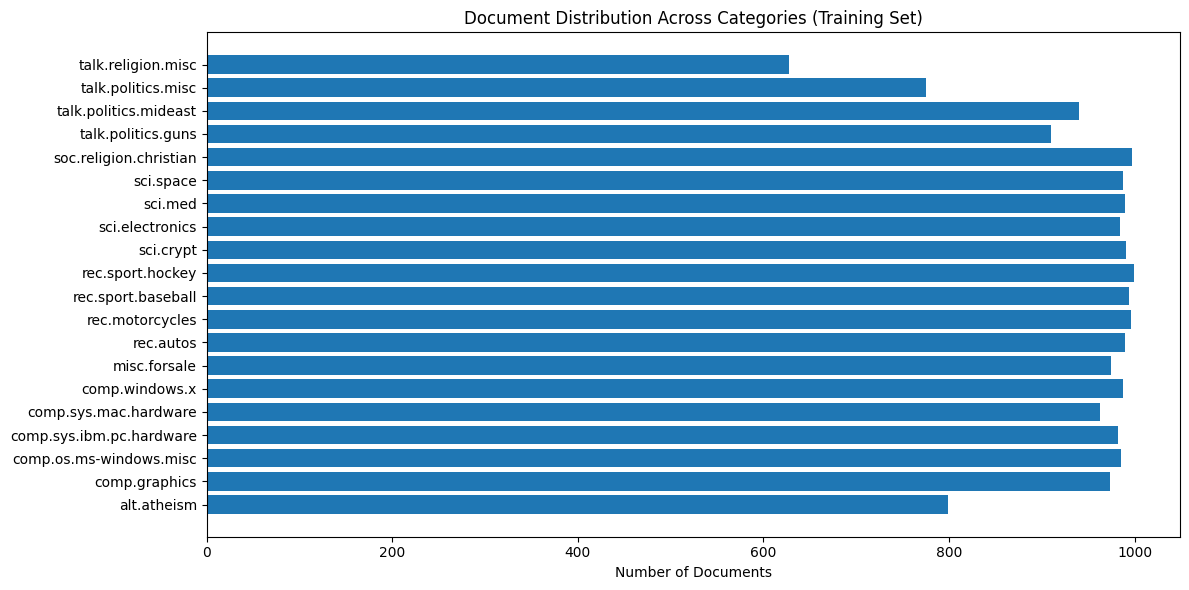

In [15]:
plt.figure(figsize=(12, 6))
categories = [news_data.target_names[i] for i in sorted(category_counts.keys())]
counts = [category_counts[i] for i in sorted(category_counts.keys())]
plt.barh(categories, counts)
plt.xlabel('Number of Documents')
plt.title('Document Distribution Across Categories (Training Set)')
plt.tight_layout()
plt.show()

In [16]:
df = pd.DataFrame({
    'text': news_data.data,
    'category': [news_data.target_names[t] for t in news_data.target],
    'category_id': news_data.target,
    'word_count': doc_lengths
})
df.head()

,text,category,category_id,word_count
0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...,rec.sport.hockey,10,157
1,From: mblawson@midway.ecn.uoknor.edu (Matthew ...,comp.sys.ibm.pc.hardware,3,134
2,From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject...,talk.politics.mideast,17,568
3,From: guyd@austin.ibm.com (Guy Dawson)\nSubjec...,comp.sys.ibm.pc.hardware,3,538
4,From: Alexander Samuel McDiarmid <am2o+@andrew...,comp.sys.mac.hardware,4,150


#PRE-PROCESSING


In [17]:
def preprocess_text(text):
  text = text.lower()
  text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text)  # remove emails
  text = re.sub(r'http[s]?://\S+', ' ', text) # Remove urls
  text = re.sub(r'[^a-z\s]', ' ', text) # Remove special characters and numbers
  words = text.split()
  return ' '.join(words)

df = pd.DataFrame({'text':news_data.data, 'target':news_data.target})
df['text'] = df['text'].apply(preprocess_text)

df.head(5)

,text,target
0,from mamatha devineni ratnam subject pens fans...,10
1,from matthew b lawson subject which high perfo...,3
2,from hilmi eren subject re armenia says it cou...,17
3,from guy dawson subject re ide vs scsi dma and...,3
4,from alexander samuel mcdiarmid subject driver...,4
5,from stephen tell subject re subliminal messag...,12
6,from louis paul adams subject re number for ap...,4
7,from deepak chhabra subject re atlanta hockey ...,10
8,from deepak chhabra subject re goalie masks nn...,10
9,from ken arromdee subject re christians above ...,19


In [18]:
df['text'] = df['text'].apply(word_tokenize)
df.head(5)

,text,target
0,"[from, mamatha, devineni, ratnam, subject, pen...",10
1,"[from, matthew, b, lawson, subject, which, hig...",3
2,"[from, hilmi, eren, subject, re, armenia, says...",17
3,"[from, guy, dawson, subject, re, ide, vs, scsi...",3
4,"[from, alexander, samuel, mcdiarmid, subject, ...",4
5,"[from, stephen, tell, subject, re, subliminal,...",12
6,"[from, louis, paul, adams, subject, re, number...",4
7,"[from, deepak, chhabra, subject, re, atlanta, ...",10
8,"[from, deepak, chhabra, subject, re, goalie, m...",10
9,"[from, ken, arromdee, subject, re, christians,...",19


In [19]:
df['text'] = df['text'].apply(lambda x: [word for word in x if word not in stopwords])

In [20]:
stemmer = PorterStemmer()
df['stemmed_text'] = df['text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x]))

df.head(5)

,text,target,stemmed_text
0,"[mamatha, devineni, ratnam, subject, pens, fan...",10,mamatha devineni ratnam subject pen fan reacti...
1,"[matthew, b, lawson, subject, high, performanc...",3,matthew b lawson subject high perform vlb vide...
2,"[hilmi, eren, subject, armenia, says, could, s...",17,hilmi eren subject armenia say could shoot tur...
3,"[guy, dawson, subject, ide, vs, scsi, dma, det...",3,guy dawson subject ide vs scsi dma detach orig...
4,"[alexander, samuel, mcdiarmid, subject, driver...",4,alexand samuel mcdiarmid subject driver organ ...
5,"[stephen, tell, subject, subliminal, message, ...",12,stephen tell subject sublimin messag flash tv ...
6,"[louis, paul, adams, subject, number, applied,...",4,loui paul adam subject number appli engin orga...
7,"[deepak, chhabra, subject, atlanta, hockey, he...",10,deepak chhabra subject atlanta hockey hell nnt...
8,"[deepak, chhabra, subject, goalie, masks, nntp...",10,deepak chhabra subject goali mask nntp post ho...
9,"[ken, arromdee, subject, christians, law, clar...",19,ken arromde subject christian law clarif pe or...


In [21]:
# X = df['text']
# y = df['target']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [22]:
# vectorizer = TfidfVectorizer()
# X_train_vec = vectorizer.fit_transform(X_train)
# X_test_vec = vectorizer.transform(X_test)

# print(X_train_vec.shape)
# print(X_test_vec.shape)


#Vocab

# Model

In [23]:
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.optim import Adam

In [24]:
class Model(nn.Module):
  def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout):
      super().__init__()
      self.embedding = nn.Embedding(vocab_size, embedding_dim)
      self.convs = nn.ModuleList([
          nn.Conv1d(
              in_channels=embedding_dim,
              out_channels=n_filters,
              kernel_size=fs
          )
          for fs in filter_sizes
      ])
      self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
      self.dropout = nn.Dropout(dropout)

  def forward(self, text):
    embed = self.embedding(text)
    embed = embed.permute(0,2,1)
    conved = [F.relu(conv(embed)) for conv in self.convs]
    pooled = [F.max_pool1d(c, c.size(2)).squeeze(2) for c in conved]
    cat = self.dropout(torch.cat(pooled, dim=1))
    return self.fc(cat)
